# 3장. 고객의 전체 모습 파악하기
이번에는 스포츠 센터 데이터로, 최근 1년 간 고객 수가 늘지 않는 것 같은데.. 그 이유? 그리고 어떤 고객이 계속 이용하고 있는 것인지가 궁금하다!  
이 데이터로 3장, 4장, 5장을 공부.

---
데이터 분석의 묘미는 현 데이터로 분석해 결국 **예측**하는 것이다!  
그래서 문제점을 파악하고, 문제 해결을 위한 최적의 정책을 실시하는 것.  
하지만 실제로는 데이터를 적절히 가공해 가시화하는 것만으로도 많은 정보를 얻을 수 있다. 이번 장에서는 *데이터를 가공해 현재 상황에 대해 분석*해보자.  

---
이용 데이터   
- use_log: 센터 이용이력(2018.04~2019.03)
- customer_master: 회원정보(탈퇴 회원 포함, 2019.03 시점)
- class_master: 회원 구분
- campaign_master: 행사 구분(입회비 유무. 프로모션에 의한)

## Tech 21. 데이터를 읽어들이고 확인하자

In [3]:
import pandas as pd
ul = pd.read_csv('3장/use_log.csv')
cust_m = pd.read_csv('3장/customer_master.csv')
class_m = pd.read_csv('3장/class_master.csv')
camp_m = pd.read_csv('3장/campaign_master.csv')

print(len(ul), len(cust_m), len(class_m), len(camp_m))

197428 4192 3 3


In [4]:
display(ul.head(), cust_m.head(), class_m, camp_m)

,log_id,customer_id,usedate
0,L00000049012330,AS009373,2018-04-01
1,L00000049012331,AS015315,2018-04-01
2,L00000049012332,AS040841,2018-04-01
3,L00000049012333,AS046594,2018-04-01
4,L00000049012334,AS073285,2018-04-01


,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted
0,OA832399,XXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0
1,PL270116,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0
2,OA974876,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0
3,HD024127,XXXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0
4,HD661448,XXXXX,C03,F,2015-05-01 00:00:00,NaN,CA1,0


,class,class_name,price
0,C01,0_종일,10500
1,C02,1_주간,7500
2,C03,2_야간,6000


,campaign_id,campaign_name
0,CA1,2_일반
1,CA2,0_입회비반액할인
2,CA3,1_입회비무료


가장 중심이 되어 분석할 데이터는 customer, use_log이며  
여기서는 고객 현황에 대해 분석할 것이므로, customer 데이터에 대해 먼저 살펴보자. 

## Tech 22. 고객 데이터를 가공하자(조인)
cust_m을 기본으로, class_m과 camp_m 을 결합해 새로운 데이터 'cust_join'을 만든다.

In [5]:
cust_join = pd.merge(cust_m, class_m, on = 'class', how='left')
cust_join = pd.merge(cust_join, camp_m, on = 'campaign_id', how='left')
cust_join.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name
0,OA832399,XXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0,0_종일,10500,2_일반
1,PL270116,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0,0_종일,10500,2_일반
2,OA974876,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0,0_종일,10500,2_일반
3,HD024127,XXXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0,0_종일,10500,2_일반
4,HD661448,XXXXX,C03,F,2015-05-01 00:00:00,NaN,CA1,0,2_야간,6000,2_일반


In [6]:
print(len(cust_m))
print(len(cust_join)) #행 개수는 변함X, cust_m을 기준으로 조인했으므로.

4192
4192


In [7]:
#결측치 확인
cust_join.isna().sum()

customer_id         0
name                0
class               0
gender              0
start_date          0
end_date         2842
campaign_id         0
is_deleted          0
class_name          0
price               0
campaign_name       0
dtype: int64

조인할때 키가 없거나 조인이 잘못되면 자동으로 결측치가 들어가게 됨.  
그러므로 조인 후에는 결측치를 확인해야 함! 하지만 여기선 원래 결측치가 있던 end_date에만 결측치가 있으므로 데이터가 정확히 들어갔음을 확인함.

In [8]:
cust_join['customer_id'].nunique() #전부 고유한 고객만 있음

4192

## Tech 23. 고객 데이터를 집계하자
이제 만든 고객 데이터인 'cust_join'으로 간단한 데이터 분석을 해보자.  

먼저, 무엇을 집계할지를 생각해본다.(무엇이 궁금한가?) 예를 들면..
- 어떤 회원과 어떤 캠페인이 많은가?
- 언제 입회/탈퇴가 많은가?
- 남녀 비율은?
- 탈퇴할 때까지의 평균 기간은 며칠인가?

In [9]:
cust_join.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name
0,OA832399,XXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0,0_종일,10500,2_일반
1,PL270116,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0,0_종일,10500,2_일반
2,OA974876,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0,0_종일,10500,2_일반
3,HD024127,XXXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0,0_종일,10500,2_일반
4,HD661448,XXXXX,C03,F,2015-05-01 00:00:00,NaN,CA1,0,2_야간,6000,2_일반


In [10]:
#캠페인 구분 현황 
round((cust_join.groupby('campaign_name')['customer_id'].count() / cust_join.shape[0])*100,1)

campaign_name
0_입회비반액할인    15.5
1_입회비무료      11.7
2_일반         72.8
Name: customer_id, dtype: float64

In [11]:
#회원 구분 현황
cust_join.groupby('class_name')['customer_id'].count()

class_name
0_종일    2045
1_주간    1019
2_야간    1128
Name: customer_id, dtype: int64

In [12]:
round((cust_join.groupby('class_name')['customer_id'].count() / cust_join.shape[0])*100,1)

class_name
0_종일    48.8
1_주간    24.3
2_야간    26.9
Name: customer_id, dtype: float64

In [13]:
#성별 현황
cust_join.groupby('gender')['customer_id'].count()

gender
F    1983
M    2209
Name: customer_id, dtype: int64

In [14]:
#탈퇴자 현황
round((cust_join.groupby('is_deleted')['customer_id'].count() / cust_join.shape[0])*100,1)

is_deleted
0    67.8
1    32.2
Name: customer_id, dtype: float64

현황을 보면,  
- 회원은 종일권이 거의 절반 > 야간 > 주간 
- 캠페인은 일반이 대다수 > 반액할인 > 무료 (일반권 70%, 프로모션에 의한 가입 30%)
- 성별은 남자>여자
- 탈퇴자는 생각보다 많다.. 전체의 32%

---
이런 것들을 보면 궁금한 점이 생긴다. 여러 가설들이나(프로모션에 의해 가입한 사람이 더 탈퇴를 적게 했을까?), 아님 캠페인 시행 시기에 따라 어떻게 달라졌는지? 성별과 회원권(class)와의 관계? 해마다 가입한 인원은 몇명일까? 등등.  
이런 것들은 집계해서 알아보는 것도 좋고, 현장 사람들에게 질문해도 좋다. 적극적으로 의견을 청취하자.  

In [15]:
#시험 삼아 start_date가 2018.04.01 ~ 2019.03.31인 가입 인원을 집계해보자.
cust_join.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name
0,OA832399,XXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0,0_종일,10500,2_일반
1,PL270116,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0,0_종일,10500,2_일반
2,OA974876,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0,0_종일,10500,2_일반
3,HD024127,XXXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0,0_종일,10500,2_일반
4,HD661448,XXXXX,C03,F,2015-05-01 00:00:00,NaN,CA1,0,2_야간,6000,2_일반


In [16]:
cust_join.dtypes

customer_id      object
name             object
class            object
gender           object
start_date       object
end_date         object
campaign_id      object
is_deleted        int64
class_name       object
price             int64
campaign_name    object
dtype: object

In [17]:
#start_date를 datetime으로 변경
cust_join['start_date'] = pd.to_datetime(cust_join['start_date'])
cust_start = cust_join[(cust_join['start_date'] >= "2018-04-01 00:00:00") & (cust_join['start_date']<="2019-03-31 23:59:59")]
cust_start

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name
2816,PL995085,XXXXXX,C01,M,2018-04-01,2018-08-31 00:00:00,CA3,1,0_종일,10500,1_입회비무료
2817,PL320453,XXX,C01,M,2018-04-01,2018-10-31 00:00:00,CA3,1,0_종일,10500,1_입회비무료
2818,AS823436,XXXXX,C01,F,2018-04-01,2018-12-31 00:00:00,CA3,1,0_종일,10500,1_입회비무료
2819,TS894938,XXXXXX,C01,M,2018-04-01,2019-02-28 00:00:00,CA3,1,0_종일,10500,1_입회비무료
2820,HI697849,XXXXX,C03,M,2018-04-01,2018-07-31 00:00:00,CA3,1,2_야간,6000,1_입회비무료
...,...,...,...,...,...,...,...,...,...,...,...
4187,HD676663,XXXX,C01,M,2019-03-14,NaN,CA1,0,0_종일,10500,2_일반
4188,HD246549,XXXXX,C01,F,2019-03-14,NaN,CA1,0,0_종일,10500,2_일반
4189,GD037007,XXXXX,C03,M,2019-03-14,NaN,CA1,0,2_야간,6000,2_일반
4190,OA953150,XXXXX,C01,M,2019-03-14,NaN,CA1,0,0_종일,10500,2_일반


In [18]:
print(len(cust_start)) #이 기간 동안 가입한 사람은 1376명 

1376


## Tech 24. 최신 고객 데이터를 집계하자.
이번에는 가장 최신 월(2019년 3월) 고객 데이터만 뽑아 집계해보자.

In [19]:
#2019년 3월의 고객만 추출하기
## 이 기간에 탈퇴를 하면 안 되므로 1)end_date가 2019.03.31 이후이거나 2)탈퇴를 한 적이 없어야 함.
cust_join['end_date'] = pd.to_datetime(cust_join['end_date'])
cust_new = cust_join[(cust_join['end_date'] >= pd.to_datetime("20190331")) | (cust_join['end_date'].isnull())]
cust_new

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name
0,OA832399,XXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반
1,PL270116,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반
2,OA974876,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반
3,HD024127,XXXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반
4,HD661448,XXXXX,C03,F,2015-05-01,NaT,CA1,0,2_야간,6000,2_일반
...,...,...,...,...,...,...,...,...,...,...,...
4187,HD676663,XXXX,C01,M,2019-03-14,NaT,CA1,0,0_종일,10500,2_일반
4188,HD246549,XXXXX,C01,F,2019-03-14,NaT,CA1,0,0_종일,10500,2_일반
4189,GD037007,XXXXX,C03,M,2019-03-14,NaT,CA1,0,2_야간,6000,2_일반
4190,OA953150,XXXXX,C01,M,2019-03-14,NaT,CA1,0,0_종일,10500,2_일반


In [20]:
len(cust_new)

2953

In [21]:
cust_new['end_date'].unique()

array([                          'NaT', '2019-03-31T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [22]:
#전체 4천여개 데이터에서 약 3천개만 골라냈다.
#이제는 여기서 어떤 회원권을 많이 쓰는지 구분해보기
cust_new.groupby('class_name')['customer_id'].count()

class_name
0_종일    1444
1_주간     696
2_야간     813
Name: customer_id, dtype: int64

In [23]:
round((cust_new.groupby('class_name')['customer_id'].count()/ cust_new.shape[0])*100,1)

class_name
0_종일    48.9
1_주간    23.6
2_야간    27.5
Name: customer_id, dtype: float64

In [24]:
#어떤 캠페인으로 가입했는지
cust_new.groupby('campaign_name')['customer_id'].count()

campaign_name
0_입회비반액할인     311
1_입회비무료       242
2_일반         2400
Name: customer_id, dtype: int64

In [25]:
round((cust_new.groupby('campaign_name')['customer_id'].count()/ cust_new.shape[0])*100,1)

campaign_name
0_입회비반액할인    10.5
1_입회비무료       8.2
2_일반         81.3
Name: customer_id, dtype: float64

In [26]:
#성별
cust_new.groupby('gender')['customer_id'].count()

gender
F    1400
M    1553
Name: customer_id, dtype: int64

In [27]:
round((cust_new.groupby('gender')['customer_id'].count()/ cust_new.shape[0])*100,1)

gender
F    47.4
M    52.6
Name: customer_id, dtype: float64

앞서 전체 데이터(cust_join)에 대해 뽑았던 것과 비율이 크게 다르진 않음.  
**=> 특정 회원권이나 성별이 탈퇴한 것이 아님!**  
그리고 캠페인은 비율이 좀 다름. 전체에서는 일반 가입이 70%였는데, 이 데이터에선 일반 가입이 80%임. -> **즉, 입회 캠페인은 회원 비율 변화에 영향을 미친다!**

## Tech 25. 이용 이력 데이터를 집계하자
- 이번에는 이용이력(ul) 데이터를 분석. 이는 고객 데이터랑은 다르게 *시간적인 요소*를 분석할 수 있음.
- 예를 들어, 한 달 이용 횟수 변화/ 회원이 스포츠센터를 정기적으로 이용하는지 or 비정기적으로 이용하는지 등등..

In [28]:
ul.head()

,log_id,customer_id,usedate
0,L00000049012330,AS009373,2018-04-01
1,L00000049012331,AS015315,2018-04-01
2,L00000049012332,AS040841,2018-04-01
3,L00000049012333,AS046594,2018-04-01
4,L00000049012334,AS073285,2018-04-01


월 이용 횟수의 평균값, 중앙값, 최댓값, 최솟값과 정기적 이용 여부를 알아보자. -> cust_join 데이터에 추가하기!

In [29]:
#데이터를 시간으로 변경
ul.dtypes

log_id         object
customer_id    object
usedate        object
dtype: object

In [30]:
ul['usedate'] = pd.to_datetime(ul['usedate'])
#연월로 변경
ul['연월'] = ul['usedate'].dt.strftime("%Y%m")
ul.head()

,log_id,customer_id,usedate,연월
0,L00000049012330,AS009373,2018-04-01,201804
1,L00000049012331,AS015315,2018-04-01,201804
2,L00000049012332,AS040841,2018-04-01,201804
3,L00000049012333,AS046594,2018-04-01,201804
4,L00000049012334,AS073285,2018-04-01,201804


In [31]:
#연월, 고객별 이용횟수를 알아보자!
ul_month = ul.groupby(['연월', 'customer_id'], as_index = False).count() 
#as_index=False 인자를 넣으면 연월, customer_id가 인덱스가 아니게 됨. 주의점은 groupby 메서드 안에 넣기!
ul_month

,연월,customer_id,log_id,usedate
0,201804,AS002855,4,4
1,201804,AS009013,2,2
2,201804,AS009373,3,3
3,201804,AS015315,6,6
4,201804,AS015739,7,7
...,...,...,...,...
36837,201903,TS995853,8,8
36838,201903,TS998593,8,8
36839,201903,TS999079,3,3
36840,201903,TS999231,6,6


In [32]:
#log_id -> cnt 변경
ul_month.rename(columns = {'log_id':'cnt'}, inplace=True)
#usedate 열 삭제
ul_month.drop('usedate', axis=1, inplace=True)
ul_month.head()

,연월,customer_id,cnt
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7


In [33]:
#이렇게만 끝내면 전혀 어떠한 정보도 없음. 고객별 평균, 중앙, 최댓, 최솟값을 집계
import numpy as np
ul_month.groupby('customer_id')['cnt'].agg([np.mean, np.median, np.max, np.min])

,mean,median,amax,amin
customer_id,,,,
AS002855,4.500000,5.0,7,2
AS008805,4.000000,4.0,8,1
AS009013,2.000000,2.0,2,2
AS009373,5.083333,5.0,7,3
AS015233,7.545455,7.0,11,4
...,...,...,...,...
TS995853,9.500000,9.5,11,8
TS998593,8.142857,8.0,9,7
TS999079,4.916667,5.5,9,2


In [34]:
#np를 안쓰는 경우..
ul_month.groupby('customer_id')['cnt'].agg(['mean','median','max','min'])

,mean,median,max,min
customer_id,,,,
AS002855,4.500000,5.0,7,2
AS008805,4.000000,4.0,8,1
AS009013,2.000000,2.0,2,2
AS009373,5.083333,5.0,7,3
AS015233,7.545455,7.0,11,4
...,...,...,...,...
TS995853,9.500000,9.5,11,8
TS998593,8.142857,8.0,9,7
TS999079,4.916667,5.5,9,2


In [35]:
#이렇게 순서를 바꿔도 된다.편한거 쓰자~
ul_month.groupby('customer_id').agg(['mean','median','max','min'])['cnt']

,mean,median,max,min
customer_id,,,,
AS002855,4.500000,5.0,7,2
AS008805,4.000000,4.0,8,1
AS009013,2.000000,2.0,2,2
AS009373,5.083333,5.0,7,3
AS015233,7.545455,7.0,11,4
...,...,...,...,...
TS995853,9.500000,9.5,11,8
TS998593,8.142857,8.0,9,7
TS999079,4.916667,5.5,9,2


In [36]:
ul_cust = ul_month.groupby('customer_id')['cnt'].agg(['mean','median','max','min'])
#인덱스 삭제 (기존 인덱스는 버리지 않는다)
ul_cust = ul_cust.reset_index(drop=False)
ul_cust.head() #<- 최종적으로, 고객별로 평균/중위/최대/최소 월 사용수

,customer_id,mean,median,max,min
0,AS002855,4.500000,5.0,7,2
1,AS008805,4.000000,4.0,8,1
2,AS009013,2.000000,2.0,2,2
3,AS009373,5.083333,5.0,7,3
4,AS015233,7.545455,7.0,11,4


- 해석: 고객번호 AS002855인 사람은 월 평균 4.5회, 중위값 5회, 월 최대 7회, 월 최소 2회를 이용했군.

## Tech 26. 이용 이력 데이터(ul)로부터 정기 이용 플래그(0-1 coding)를 작성하자.
스포츠센터의 경우는 지속 요소 중 하나가 '습관'이다.  
그래서 여기서는 정기적으로 센터를 이용하는 고객을 특정해보자. 이는 정의하는 방법에 따라 다르지만, 매주 같은 요일에 왔는지 아닌지로 판단해보자.  

--
여기서는 임의로, 고객별로 월/요일별로 방문한 횟수의 최댓값이 4 이상인 요일이 하나라도 있는 회원이면 플래그를 1로 처리한다. 즉 0,1로 구성된 binary 변수인 "flag"를 만든다.

In [37]:
ul.head()

,log_id,customer_id,usedate,연월
0,L00000049012330,AS009373,2018-04-01,201804
1,L00000049012331,AS015315,2018-04-01,201804
2,L00000049012332,AS040841,2018-04-01,201804
3,L00000049012333,AS046594,2018-04-01,201804
4,L00000049012334,AS073285,2018-04-01,201804


In [38]:
#앞에서 월은 뽑았는데 요일이 없으니 요일을 뽑자.
ul['weekday'] = ul['usedate'].dt.weekday
ul.head()

,log_id,customer_id,usedate,연월,weekday
0,L00000049012330,AS009373,2018-04-01,201804,6
1,L00000049012331,AS015315,2018-04-01,201804,6
2,L00000049012332,AS040841,2018-04-01,201804,6
3,L00000049012333,AS046594,2018-04-01,201804,6
4,L00000049012334,AS073285,2018-04-01,201804,6


- 월별: 컬럼 '연월' 
- 요일별: 컬럼 'weekday'

In [39]:
#고객별, 월별, 요일별 방문횟수 카운트
ul_week = ul.groupby(['customer_id', '연월', 'weekday'], as_index=False).count()
ul_week.rename(columns = {'log_id': 'cnt'}, inplace=True)
del ul_week['usedate']
ul_week.head()

,customer_id,연월,weekday,cnt
0,AS002855,201804,5,4
1,AS002855,201805,2,1
2,AS002855,201805,5,4
3,AS002855,201806,5,5
4,AS002855,201807,1,1


In [40]:
#한 회원 기록을 살펴보자..(cnt가 0인 건 집계 안된다)
ul_week.sort_values(['customer_id','연월', 'weekday'])
    #2855번 회원은 2018년 4월 토요일에 4번, 2018년 5월에 요일번호2번(수)에 1번, 요일번호5번(토)에 4번 방문했군.
    #요일번호 5번(토요일)에 자주 온 것으로 보임. 특히 1달에 4번이면 매주 왔다는 거니까, 토요일이 헬스데이일 수도?

,customer_id,연월,weekday,cnt
0,AS002855,201804,5,4
1,AS002855,201805,2,1
2,AS002855,201805,5,4
3,AS002855,201806,5,5
4,AS002855,201807,1,1
...,...,...,...,...
93328,TS999855,201901,1,1
93329,TS999855,201901,5,4
93330,TS999855,201901,6,1
93331,TS999855,201902,5,4


In [41]:
#그럼 플래그 처리를 해보자.
#고객별 cnt 최댓값이 4 이상이면 고객아이디 옆에 플래그 1을 넣자.

ul_week = ul_week.groupby('customer_id', as_index=False)[['cnt']].max()
ul_week

,customer_id,cnt
0,AS002855,5
1,AS008805,4
2,AS009013,2
3,AS009373,5
4,AS015233,5
...,...,...
4187,TS995853,5
4188,TS998593,5
4189,TS999079,5
4190,TS999231,5


In [42]:
ul_week['flag'] = ul_week['cnt'].apply(lambda x: 1 if x>=4 else 0)
ul_week.head()

,customer_id,cnt,flag
0,AS002855,5,1
1,AS008805,4,1
2,AS009013,2,0
3,AS009373,5,1
4,AS015233,5,1


In [43]:
#먼저 새로운 컬럼인 'flag'를 모두 0으로 채움
ul_week['flag'] = 0

#cnt 값이 4 이상이면 이를 1로 바꾼다.(불린 인덱싱 활용: 굳이 for문을 안써도 된다! for문은 너무 시간이 오래걸려서..)
#불린 변수(cnt가 4 이상인 변수의 인덱스는 True)
is_over4 = (ul_week['cnt']>=4)
#위의 인덱스로 인덱싱
ul_week.loc[(is_over4), 'flag'] =1
ul_week.head()

,customer_id,cnt,flag
0,AS002855,5,1
1,AS008805,4,1
2,AS009013,2,0
3,AS009373,5,1
4,AS015233,5,1


In [44]:
## 다른 방법
ul_week['flag'] = 0
ul_week['flag'] = ul_week['flag'].where(ul_week['cnt']<4, 1) #조건이 참이면 0이고, 거짓이면 1을 넣는다. (좀 헷갈림..)
ul_week.head()

,customer_id,cnt,flag
0,AS002855,5,1
1,AS008805,4,1
2,AS009013,2,0
3,AS009373,5,1
4,AS015233,5,1


## Tech 27. 고객 데이터(cust_join)와 이용이력 데이터(ul_cust, ul_week)를 결합하자.

In [45]:
#앞서 만든 데이터들
display(cust_join.head(), ul_cust.head(), ul_week.head())

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name
0,OA832399,XXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반
1,PL270116,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반
2,OA974876,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반
3,HD024127,XXXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반
4,HD661448,XXXXX,C03,F,2015-05-01,NaT,CA1,0,2_야간,6000,2_일반


,customer_id,mean,median,max,min
0,AS002855,4.500000,5.0,7,2
1,AS008805,4.000000,4.0,8,1
2,AS009013,2.000000,2.0,2,2
3,AS009373,5.083333,5.0,7,3
4,AS015233,7.545455,7.0,11,4


,customer_id,cnt,flag
0,AS002855,5,1
1,AS008805,4,1
2,AS009013,2,0
3,AS009373,5,1
4,AS015233,5,1


In [46]:
print(len(cust_join), len(ul_cust), len(ul_week))

4192 4192 4192


모든 행의 수가 같다. 왜냐하면 cust_join은 전체 고객정보(탈퇴자 포함)이기에 customer_id가 고유하고, 나머지 ul_cust와 ul_week도 탈퇴자 포함해 customer_id가 고유하기 때문에..

In [47]:
#cust_join을 기준으로 left join
cust_join = pd.merge(cust_join, ul_cust, on = 'customer_id', how='left')
cust_join = pd.merge(cust_join, ul_week[['customer_id', 'flag']], on = 'customer_id', how='left') #ul_week에서 cnt 열은 버린다.
cust_join.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,flag
0,OA832399,XXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.833333,5.0,8,2,1
1,PL270116,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,5.083333,5.0,7,3,1
2,OA974876,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.583333,5.0,6,3,1
3,HD024127,XXXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.833333,4.5,7,2,1
4,HD661448,XXXXX,C03,F,2015-05-01,NaT,CA1,0,2_야간,6000,2_일반,3.916667,4.0,6,1,1


In [48]:
print(len(cust_join))

4192


In [49]:
cust_join.isnull().sum() #처음에 본 데이터와 동일하게, end_date에만 2842개의 결측치가 있다. 결합은 문제없이 성공!

customer_id         0
name                0
class               0
gender              0
start_date          0
end_date         2842
campaign_id         0
is_deleted          0
class_name          0
price               0
campaign_name       0
mean                0
median              0
max                 0
min                 0
flag                0
dtype: int64

## Tech 28. 회원 기간을 계산하자
이제 cust_join 데이터를 보면, 기존의 고객 정보뿐 아니라 이용이력 데이터도 모두 들어가서 데이터 분석이 가능해짐!  
여기에 분석에 앞서, '회원 기간'이 어느 정도인지 컬럼 'mem_period'를 추가해두자.

In [50]:
import datetime as dt 
now = dt.datetime.now() 
delta = dt.timedelta(hours=3) #3시간을 뺌. 이러한 datetime 에서 지원하는 메서드는 딱 days, hours, seconds 뿐(시간관련)이라서, month,year 같은것을 쓰려면 relativedelta를 이용하자.
diff = now - delta

diff

datetime.datetime(2022, 4, 5, 12, 23, 56, 949890)

In [51]:
from dateutil.relativedelta import relativedelta 
import datetime as dt
now = dt.datetime.now() 
delta = relativedelta(months=3) #3달을 뺌
diff = now - delta
diff

datetime.datetime(2022, 1, 5, 15, 23, 57, 210400)

In [52]:
#회원기간은 단순히 start_date ~ end_date의 차이.
## end_date가 비워진 경우는 임의로 2019-04-30일이라고 해보자.(2019-03-31로 안 하는 것은 2019-03-31에 진짜로 탈퇴한 사람도 있기 때문에 구분이 힘들어서)

from dateutil.relativedelta import relativedelta
#cal_date를 end_date로 임의로 넣어두기
cust_join['cal_date'] = cust_join['end_date']
cust_join.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,flag,cal_date
0,OA832399,XXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.833333,5.0,8,2,1,NaT
1,PL270116,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,5.083333,5.0,7,3,1,NaT
2,OA974876,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.583333,5.0,6,3,1,NaT
3,HD024127,XXXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.833333,4.5,7,2,1,NaT
4,HD661448,XXXXX,C03,F,2015-05-01,NaT,CA1,0,2_야간,6000,2_일반,3.916667,4.0,6,1,1,NaT


In [53]:
#end_date가 비워진 경우, cal_date엔 '2019-04-30'으로 채운다.
cust_join['cal_date'].fillna(pd.to_datetime('20190430'), inplace=True)
cust_join.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,flag,cal_date
0,OA832399,XXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.833333,5.0,8,2,1,2019-04-30
1,PL270116,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,5.083333,5.0,7,3,1,2019-04-30
2,OA974876,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.583333,5.0,6,3,1,2019-04-30
3,HD024127,XXXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.833333,4.5,7,2,1,2019-04-30
4,HD661448,XXXXX,C03,F,2015-05-01,NaT,CA1,0,2_야간,6000,2_일반,3.916667,4.0,6,1,1,2019-04-30


In [54]:
#회원기간을 계산하는 'mem_period' 컬럼 추가
cust_join['mem_period'] = (cust_join['cal_date'] - cust_join['start_date']) / np.timedelta64(1, 'M') #단위가 '월'이므로 추가
cust_join.dtypes

customer_id              object
name                     object
class                    object
gender                   object
start_date       datetime64[ns]
end_date         datetime64[ns]
campaign_id              object
is_deleted                int64
class_name               object
price                     int64
campaign_name            object
mean                    float64
median                  float64
max                       int64
min                       int64
flag                      int64
cal_date         datetime64[ns]
mem_period              float64
dtype: object

In [55]:
cust_join.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,flag,cal_date,mem_period
0,OA832399,XXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.833333,5.0,8,2,1,2019-04-30,47.968131
1,PL270116,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,5.083333,5.0,7,3,1,2019-04-30,47.968131
2,OA974876,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.583333,5.0,6,3,1,2019-04-30,47.968131
3,HD024127,XXXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.833333,4.5,7,2,1,2019-04-30,47.968131
4,HD661448,XXXXX,C03,F,2015-05-01,NaT,CA1,0,2_야간,6000,2_일반,3.916667,4.0,6,1,1,2019-04-30,47.968131


In [56]:
## 다른 방법(relativedelta 사용)
cust_join['mem_period'] = 0
for i in range(len(cust_join)):
    delta = relativedelta(cust_join.loc[i, 'cal_date'], cust_join.loc[i, 'start_date']) #두 기간의 차이를 계산 
    cust_join.loc[i, 'mem_period'] = delta.years*12 + delta.months #위의 delta 값을 mem_period에 넣음 (단위: month)
    
cust_join.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,flag,cal_date,mem_period
0,OA832399,XXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.833333,5.0,8,2,1,2019-04-30,47
1,PL270116,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,5.083333,5.0,7,3,1,2019-04-30,47
2,OA974876,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.583333,5.0,6,3,1,2019-04-30,47
3,HD024127,XXXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.833333,4.5,7,2,1,2019-04-30,47
4,HD661448,XXXXX,C03,F,2015-05-01,NaT,CA1,0,2_야간,6000,2_일반,3.916667,4.0,6,1,1,2019-04-30,47


In [57]:
cust_join.dtypes

customer_id              object
name                     object
class                    object
gender                   object
start_date       datetime64[ns]
end_date         datetime64[ns]
campaign_id              object
is_deleted                int64
class_name               object
price                     int64
campaign_name            object
mean                    float64
median                  float64
max                       int64
min                       int64
flag                      int64
cal_date         datetime64[ns]
mem_period                int64
dtype: object

첫번째 방법은 mem_period가 float이나, 두번쨰 방법은 int(숫자)로 들어감. 우리는 두번쨰 방법을 사용해서 분석을 하도록 하자.

## Tech 29. 고객 행동의 각종 통계량을 파악하자.

In [123]:
cust_join.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,flag,cal_date,mem_period
0,OA832399,XXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.833333,5.0,8,2,1,2019-04-30,47
1,PL270116,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,5.083333,5.0,7,3,1,2019-04-30,47
2,OA974876,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.583333,5.0,6,3,1,2019-04-30,47
3,HD024127,XXXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.833333,4.5,7,2,1,2019-04-30,47
4,HD661448,XXXXX,C03,F,2015-05-01,NaT,CA1,0,2_야간,6000,2_일반,3.916667,4.0,6,1,1,2019-04-30,47


In [124]:
#전체 고객을 대상으로, 월평균/월중위값/월최소/월최대 이용횟수의 통계량을 내보자.
cust_join[['mean', 'median', 'max', 'min']].describe()

,mean,median,max,min
count,4192.000000,4192.000000,4192.000000,4192.000000
mean,5.333127,5.250596,7.823950,3.041269
std,1.777533,1.874874,2.168959,1.951565
min,1.000000,1.000000,1.000000,1.000000
25%,4.250000,4.000000,7.000000,2.000000
50%,5.000000,5.000000,8.000000,3.000000
75%,6.416667,6.500000,9.000000,4.000000
max,12.000000,12.000000,14.000000,12.000000


전체 회원에 대해, 모든 회원에 대해 1인당 월 평균 5.3회, 1인당 월 중위수 5.2회, 1인당 월 최대이용횟수 7.8회, 1인당 월 최소이용횟수 3회입니다.  
결과적으로 고객 1인당 한달에 약 5회 사용한다고 볼 수 있음.

In [126]:
#전체 고객 대상 flag 현황
cust_join.groupby('flag').count()['customer_id']

flag
0     779
1    3413
Name: customer_id, dtype: int64

In [128]:
round(cust_join.groupby('flag').count()['customer_id'] / cust_join.shape[0] *100,1)

flag
0    18.6
1    81.4
Name: customer_id, dtype: float64

flag가 1이라는 것은 아까전에 1달에 특정 요일에 4번 이상 이용한 적이 있으면 부여되었음.  
위의 결과를 확인해보면, 정기적으로 1달에 특정 요일마다 오는 사람이 3413명(81%)으로, 정기적으로 이용하는 사람 수가 많다. 헬스장에 특정 요일마다 주기적으로 방문하는 사람이 무려 전체의 80%!!

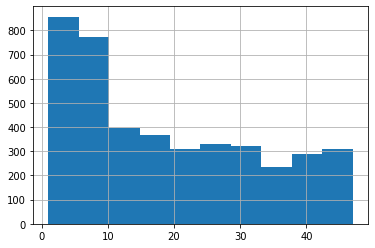

In [129]:
#마지막으로, 회원 기간의 분포는?
import matplotlib.pyplot as plt
cust_join['mem_period'].hist()

(array([857., 774., 395., 368., 311., 331., 323., 237., 288., 308.]),
 array([ 1. ,  5.6, 10.2, 14.8, 19.4, 24. , 28.6, 33.2, 37.8, 42.4, 47. ]),
 <a list of 10 Patch objects>)

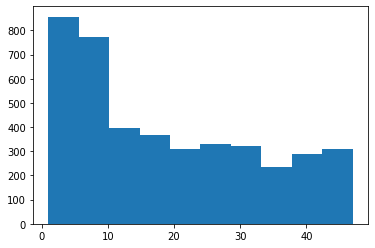

In [130]:
plt.hist(cust_join['mem_period'])

회원 기간 단위가 "달(month)"인데, 가장 많은 건 0~10개월 사이가 많고, 10개월 이상 다니고 있는 회원 수는 비슷비슷하다.  
10개월을 기점으로 확 꺾이니까 마의 10개월이군... 10개월 넘게 쓰도록 뭔가 유인책을 생각해보면 좋겠음! 짧은 기간에 고객이 빠져나가는 업계인 듯.

## Tech 30. 탈퇴하는 회원과 지속하는 회원의 차이를 파악하자
그렇다면 탈퇴회원과 계속 다니는 회원 간에는 어떤 차이가 있을까?

In [131]:
cust_join.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,flag,cal_date,mem_period
0,OA832399,XXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.833333,5.0,8,2,1,2019-04-30,47
1,PL270116,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,5.083333,5.0,7,3,1,2019-04-30,47
2,OA974876,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.583333,5.0,6,3,1,2019-04-30,47
3,HD024127,XXXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.833333,4.5,7,2,1,2019-04-30,47
4,HD661448,XXXXX,C03,F,2015-05-01,NaT,CA1,0,2_야간,6000,2_일반,3.916667,4.0,6,1,1,2019-04-30,47


In [132]:
#탈퇴여부는 is_deleted=1이면 탈퇴, 0이면 지속
#통계량 살펴보기(탈퇴회원)
cust_join[cust_join['is_deleted'] == 1].describe()

,is_deleted,price,mean,median,max,min,flag,mem_period
count,1350.0,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000
mean,1.0,8595.555556,3.865474,3.621852,6.461481,1.821481,0.456296,8.026667
std,0.0,1949.163652,1.246385,1.270847,2.584021,0.976361,0.498271,5.033692
min,1.0,6000.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
25%,1.0,6000.000000,3.000000,3.000000,4.000000,1.000000,0.000000,4.000000
50%,1.0,7500.000000,4.000000,4.000000,7.000000,2.000000,0.000000,7.000000
75%,1.0,10500.000000,4.666667,4.500000,8.000000,2.000000,1.000000,11.000000
max,1.0,10500.000000,9.000000,9.000000,13.000000,8.000000,1.000000,23.000000


In [133]:
#지속회원
cust_join[cust_join['is_deleted'] == 0].describe()

,is_deleted,price,mean,median,max,min,flag,mem_period
count,2842.0,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000
mean,0.0,8542.927516,6.030288,6.024279,8.471147,3.620690,0.984166,23.970443
std,0.0,1977.189779,1.553587,1.599765,1.571048,2.030488,0.124855,13.746761
min,0.0,6000.000000,3.166667,3.000000,5.000000,1.000000,0.000000,1.000000
25%,0.0,6000.000000,4.833333,5.000000,7.000000,2.000000,1.000000,12.000000
50%,0.0,7500.000000,5.583333,5.500000,8.000000,3.000000,1.000000,24.000000
75%,0.0,10500.000000,7.178030,7.000000,10.000000,5.000000,1.000000,35.000000
max,0.0,10500.000000,12.000000,12.000000,14.000000,12.000000,1.000000,47.000000


탈퇴회원은 지속 회원보다 매월 이용횟수 평균, 중앙, 최대, 최솟값 모두 작음. 특히 평균,중앙값은 1.5배나 차이남(월평균 탈퇴자 월평균 3.8회 / 지속자 월평균 6회 이용)  
flag를 보면 탈퇴자는 평균이 0.45, 지속자는 0.98로 1달에 특정 요일마다 매주 방문하는 것이 지속회원은 아주 높다(거의 1에 가까움)-> 즉, 지속회원은 정기적으로 이용하는 회원이 아주 많다. 탈퇴회원은 절반은 랜덤하게 이용하고 있었다.(매주 방문하는 사람 절반, 아닌 사람 절반)  
회원기간의 경우, 탈퇴회원은 평균 8주(약 2달), 지속회원은 평균 24주(약 2년)을 유지했다.

In [134]:
#마지막으로, 다음 4장에서 이용하기 위해 cust_join 데이터를 csv로 출력해놓자.
cust_join.to_csv('customer_join.csv', index=False)